<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Learning-Model-Calibration-with-Temperature-Scaling" data-toc-modified-id="Deep-Learning-Model-Calibration-with-Temperature-Scaling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Learning Model Calibration with Temperature Scaling</a></span><ul class="toc-item"><li><span><a href="#Tokenizer" data-toc-modified-id="Tokenizer-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tokenizer</a></span></li><li><span><a href="#Model-FineTuning" data-toc-modified-id="Model-FineTuning-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model FineTuning</a></span></li><li><span><a href="#Model-Calibration" data-toc-modified-id="Model-Calibration-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model Calibration</a></span><ul class="toc-item"><li><span><a href="#Temperature-Scaling" data-toc-modified-id="Temperature-Scaling-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Temperature Scaling</a></span></li></ul></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from torch import optim
from torch.utils.data import DataLoader
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

%watermark -a 'Ethen' -d -t -v -p datasets,transformers,torch,tokenizers,numpy,pandas,matplotlib

Author: Ethen

Python implementation: CPython
Python version       : 3.7.3
IPython version      : 7.17.0

datasets    : 1.6.2
transformers: 4.4.1
torch       : 1.7.0+cu101
tokenizers  : 0.10.3
numpy       : 1.20.3
pandas      : 1.2.4
matplotlib  : 3.4.2



# Deep Learning Model Calibration with Temperature Scaling

In this article, we'll be going over two main things:

- Process of finetuning a pre-trained BERT model towards a text classification task, more specificially, the [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs/data) challenge.
- Process of evaluating model calibration and improving upong calibration error using temperature scaling.

Finetuning pre-trained models on downstream tasks has been increasingly popular these days, this notebook documents the findings on these model's calibration. Calibration in this context means does the model's predicted score reflects true probability. If the reader is not familiar with model calibration 101, there is a separate [notebook](http://ethen8181.github.io/machine-learning/model_selection/prob_calibration/prob_calibration.html) that covers this topic. Reading up till the "Measuring Calibration" section should suffice.

In [3]:
dataset_dict = load_dataset("quora")
dataset_dict

Using custom data configuration default
Reusing dataset quora (/home/mingyuliu/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})

In [4]:
dataset_dict['train'][0]

{'is_duplicate': False,
 'questions': {'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']}}

In [5]:
test_size = 0.1
val_size = 0.1
dataset_dict_test = dataset_dict['train'].train_test_split(test_size=test_size)
dataset_dict_train_val = dataset_dict_test['train'].train_test_split(test_size=val_size)

dataset_dict = DatasetDict({
    "train": dataset_dict_train_val["train"],
    "val": dataset_dict_train_val["test"],
    "test": dataset_dict_test["test"]
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 40429
    })
})

## Tokenizer

We won't be going over the details of the pre-trained tokenizer or model and only load a pre-trained one available from the huggingface model repository.

In [6]:
# https://huggingface.co/transformers/model_doc/mobilebert.html
pretrained_model_name_or_path = "google/mobilebert-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
tokenizer

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

We can feed our tokenizer directly with a pair of sentences.

In [7]:
encoded_input = tokenizer(
    'What is the step by step guide to invest in share market in india?',
    'What is the step by step guide to invest in share market?'
)
encoded_input

{'input_ids': [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Decoding the tokenized inputs, this model's tokenizer adds some special tokens such as, `[SEP]`, that is used to indicate which token belongs to which segment/pair.

In [8]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]'

The proprocessing step will be task specific, if we happen to be using another dataset, this function needs to be modified accordingly.

In [9]:
def tokenize_fn(examples):
    labels = [int(label) for label in examples['is_duplicate']]
    texts = [question['text'] for question in examples['questions']]
    texts1 = [text[0] for text in texts]
    texts2 = [text[1] for text in texts]
    tokenized_examples = tokenizer(texts1, texts2)
    tokenized_examples['labels'] = labels
    return tokenized_examples

In [10]:
dataset_dict_tokenized = dataset_dict.map(
    tokenize_fn,
    batched=True,
    num_proc=8,
    remove_columns=['is_duplicate', 'questions']
)
dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 40429
    })
})

In [11]:
dataset_dict_tokenized['train'][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'input_ids': [101,
  2129,
  2064,
  1045,
  5356,
  1037,
  3167,
  4638,
  2005,
  2489,
  1029,
  102,
  2064,
  1037,
  2711,
  5356,
  2026,
  3167,
  4638,
  1029,
  102],
 'labels': 0,
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

## Model FineTuning

Having preprocessed our raw dataset, for our text classification task, we use `AutoModelForSequenceClassification` class to load the pre-trained model, the only other argument we need to specify is the number of class/label our text classification task has. Upon instantiating the model for the first time, we'll see some warnings generated, telling us we should fine tune this model on our down stream tasks before using it. 

In [12]:
model_checkpoint = 'text_classification'
num_labels = 2

In [13]:
# we'll save the model after fine tuning it once, so we can skip the fine tuning part during
# the second round if we detect that we already have one available
if os.path.isdir(model_checkpoint):
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
else:
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, num_labels=num_labels)

print('# of parameters: ', model.num_parameters())
model

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

# of parameters:  24582914


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0): MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_features=1

In [14]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None)

We can perform all sorts of hyper parameter tuning on the fine tuning step, here we'll pick some default parameters for illustration purposes.

In [15]:
batch_size = 64
args = TrainingArguments(
    "quora",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    data_collator=data_collator,
    train_dataset=dataset_dict_tokenized["train"],
    eval_dataset=dataset_dict_tokenized['val']
)

In [16]:
if not os.path.isdir(model_checkpoint):
    trainer.train()
    model.save_pretrained(model_checkpoint)

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,0.266000,0.259760,30.191600,1205.204000
2,0.195500,0.241103,29.987800,1213.392000


In [17]:
class SoftmaxModule(nn.Module):
    """
    Add a softmax layer on top the base model. Note this does not necessarily
    mean the output score is a well-calibrated probability.
    """

    def __init__(self, model_path: str):
        super().__init__()
        self.model_path = model_path
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        scores = nn.functional.softmax(outputs.logits, dim=-1)[:, 1]
        return scores

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

softmax_module = SoftmaxModule(model_checkpoint).to(device)
softmax_module.eval()
softmax_module

SoftmaxModule(
  (model): MobileBertForSequenceClassification(
    (mobilebert): MobileBertModel(
      (embeddings): MobileBertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
        (LayerNorm): NoNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): MobileBertEncoder(
        (layer): ModuleList(
          (0): MobileBertLayer(
            (attention): MobileBertAttention(
              (self): MobileBertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=512, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output):

We define some helper functions to generate predictions for our dataset, store the predicted score and label into a pandas DataFrame.

In [19]:
def predict(model, examples, round_digits: int = 5):
    input_ids = examples['input_ids'].to(device)
    attention_mask = examples['attention_mask'].to(device)
    token_type_ids = examples['token_type_ids'].to(device)
    batch_labels = examples['labels'].detach().cpu().numpy().tolist()
    model.eval()
    with torch.no_grad():
        batch_output = model(input_ids, attention_mask, token_type_ids)

    batch_scores = np.round(batch_output.detach().cpu().numpy(), round_digits).tolist()
    return batch_scores, batch_labels

In [20]:
def predict_data_loader(model, data_loader: DataLoader) -> pd.DataFrame:
    scores = []
    labels = []
    for examples in data_loader:
        batch_scores, batch_labels = predict(model, examples)
        scores += batch_scores
        labels += batch_labels

    df_predictions = pd.DataFrame.from_dict({'scores': scores, 'labels': labels})
    return df_predictions

In [21]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)
data_loader = DataLoader(dataset_dict_tokenized['test'], collate_fn=data_collator, batch_size=128)
start = time.time()
df_predictions = predict_data_loader(softmax_module, data_loader)
end = time.time()

print('elapsed: ', end - start)
print(df_predictions.shape)
df_predictions.head()

elapsed:  28.861881017684937
(40429, 2)


,scores,labels
0,0.97060,0
1,0.87807,1
2,0.00540,0
3,0.64068,1
4,0.00003,0


## Model Calibration

### Temperature Scaling

Temperature Scaling is a post-processing technique that was proposed to improve upon the calibration error, but specifically designed for deep learning. It works by dividing the logits (output of the layer right before the final softmax layer) by a learned scalar parameter.

\begin{align}
\text{softmax} = \frac{e^{(z/T)}}{\sum_i e^{(z_i/T)}}
\end{align}

where $z$ is the logit, and $T$ is the learned temperature scaling parameter. We learn this parameter on a validation set, where $T$ is chosen to minimize negative log likelihood. As we can imagine, with $T \ge 1$, it lowers the predicted score across all classes, making the model less confident about its predictions but does not change the model's predicted maximum class.

The benefit of this approach is mainly two folds:

- Unlike a lot of post processing calibration technique, temperature scaling can be directly embedded into our deep learning module as a single additional parameter. We can export the model as is using standard serialization techniques for that specific deep learning library and perform inferencing at run time without introducing additional dependencies.
- It has been shown to provide potent calibration performance when compared to other post processing calibration techniques by the [original paper](https://arxiv.org/pdf/1706.04599.pdf).

In [22]:
class TemperatureScalingCalibrationModule(nn.Module):

    def __init__(self, model_path: str):
        super().__init__()
        self.model_path = model_path
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)

        # the single temperature scaling parameter, the initialization value doesn't
        # seem to matter that much based on some ad-hoc experimentation
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, input_ids, attention_mask, token_type_ids):
        """forward method that returns softmax-ed confidence scores."""
        outputs = self.forward_logit(input_ids, attention_mask, token_type_ids)
        scores = nn.functional.softmax(outputs, dim=-1)[:, 1]
        return scores

    def forward_logit(self, input_ids, attention_mask, token_type_ids):
        """forward method that returns logits, to be used with cross entropy loss."""
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ).logits
        return outputs / self.temperature

    def fit(self, dataset_tokenized, n_epochs: int = 3, batch_size: int = 64, lr: float = 0.01):
        """fits the temperature scaling parameter."""
        data_collator = DataCollatorWithPadding(tokenizer, padding=True)
        data_loader = DataLoader(dataset_tokenized, collate_fn=data_collator, batch_size=batch_size)

        self.freeze_base_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr)

        for epoch in trange(n_epochs):
            for examples in data_loader:
                labels = examples['labels'].long().to(device)
                input_ids = examples['input_ids'].to(device)
                attention_mask = examples['attention_mask'].to(device)
                token_type_ids = examples['token_type_ids'].to(device)

                # standard step to perform the forward and backward step
                self.zero_grad()
                predict_proba = self.forward_logit(input_ids, attention_mask, token_type_ids)
                loss = criterion(predict_proba, labels)
                loss.backward()
                optimizer.step()

        return self

    def freeze_base_model(self):
        """remember to freeze base model's parameters when training temperature scaler"""
        self.model.eval()
        for parameter in self.model.parameters():
            parameter.requires_grad = False

        return self

In [23]:
calibration_module = TemperatureScalingCalibrationModule(model_checkpoint).to(device)
calibration_module

TemperatureScalingCalibrationModule(
  (model): MobileBertForSequenceClassification(
    (mobilebert): MobileBertModel(
      (embeddings): MobileBertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
        (LayerNorm): NoNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): MobileBertEncoder(
        (layer): ModuleList(
          (0): MobileBertLayer(
            (attention): MobileBertAttention(
              (self): MobileBertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=512, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
 

In [24]:
calibration_module.fit(dataset_dict_tokenized['val'])

100%|██████████| 3/3 [01:30<00:00, 30.04s/it]


TemperatureScalingCalibrationModule(
  (model): MobileBertForSequenceClassification(
    (mobilebert): MobileBertModel(
      (embeddings): MobileBertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
        (LayerNorm): NoNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): MobileBertEncoder(
        (layer): ModuleList(
          (0): MobileBertLayer(
            (attention): MobileBertAttention(
              (self): MobileBertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=512, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
 

In [25]:
calibration_module.temperature

Parameter containing:
tensor([1.2335], device='cuda:0', requires_grad=True)

In [26]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)
data_loader = DataLoader(dataset_dict_tokenized['test'], collate_fn=data_collator, batch_size=128)
start = time.time()
df_calibrated_predictions = predict_data_loader(calibration_module, data_loader)
end = time.time()

print('elapsed: ', end - start)
print(df_calibrated_predictions.shape)
df_calibrated_predictions.head()

elapsed:  28.950477123260498
(40429, 2)


,scores,labels
0,0.94453,0
1,0.83210,1
2,0.01436,0
3,0.61511,1
4,0.00020,0


From the plot below, we can see our predicted score on the datset is concentrated on the higher end, however, from the calibration plot, it seems like the original predicted score is already pretty well calibrated, and with temperature scaling, we were able to improve upon the calibration metrics even further. Looking the the final value of the trained temperature scaling, a larger than 1 value indicates that it is indeed shrinking the predicted score to make the model less confident on its prediction.

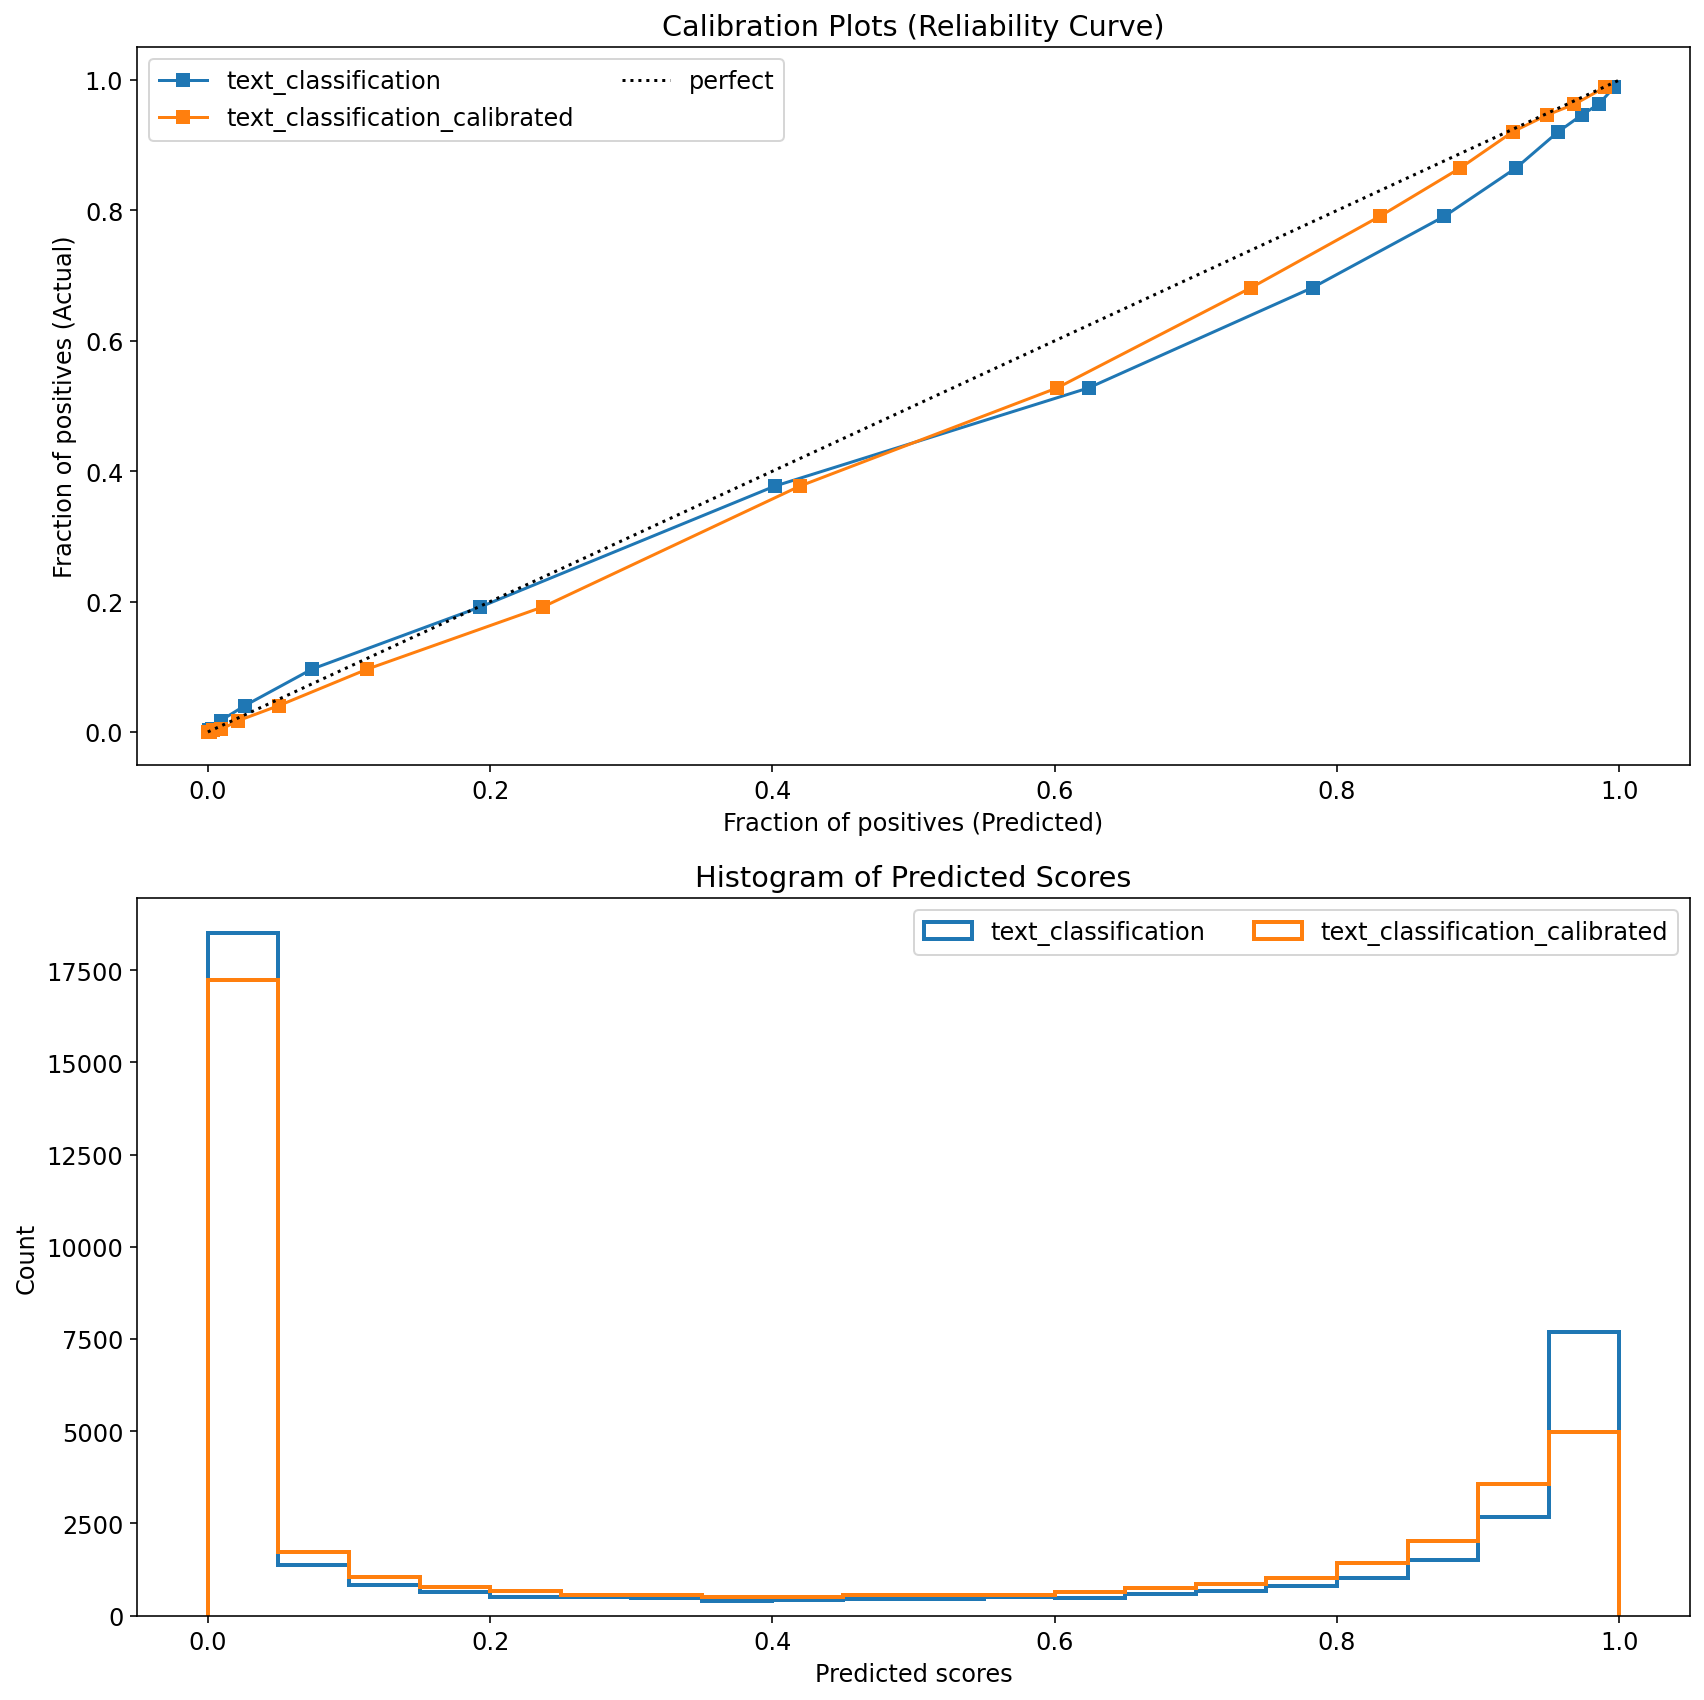

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.9635,0.8297,0.9109,0.8684,0.2412,0.0742,0.0416,text_classification
1,0.9635,0.8297,0.9109,0.8684,0.2357,0.0732,0.0276,text_classification_calibrated


In [28]:
from calibration_module.utils import compute_calibration_summary


eval_dict = {
    f'{model_checkpoint}': df_predictions,
    f'{model_checkpoint}_calibrated': df_calibrated_predictions
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams['font.size'] = 12

n_bins = 20
df_result = compute_calibration_summary(eval_dict, label_col='labels', score_col='scores', n_bins=n_bins)
df_result

There're other [papers](https://arxiv.org/pdf/2106.07998.pdf) that studies the calibration effect for state of the art models. Although it's mainly for image based models, their claim is that model size and pretraining amount doen't fully account for the differences in calibration across different models, but the primary factor seems to be on model architecture, or more explicitly models that rely on attention based mechanism are found to be better calibrated compared to convolution based mechanism.

# Reference

- [Jupyter Notebook: Fine-tuning a model on a text classification task](https://nbviewer.jupyter.org/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [Blog: Temperature Scaling for Neural Network Calibration](https://jamesmccaffrey.wordpress.com/2021/01/28/temperature-scaling-for-neural-network-calibration/)
- [Paper: On Calibration of Modern Neural Networks - Guo, Chuan and Pleiss, Geoff and Sun, Yu and Weinberger, Kilian Q. (2017)](https://arxiv.org/pdf/1706.04599.pdf)
- [Paper: Revisiting the Calibration of Modern Neural Networks - Matthias Minderer, Josip Djolonga, Rob Romijnders, Frances Hubis, Xiaohua Zhai, Neil Houlsby, Dustin Tran ,Mario Lucic (2021)](https://arxiv.org/pdf/2106.07998.pdf)